In [ ]:
#| default_exp layers

# Functional layers

> JaX/Flax implementation of functional layers.

In [ ]:
#| export
import jax
from typing import Any, Callable, Sequence, Union
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax import linen as nn
import optax

## Base layer

> First we'll define a base class that will be used by every other functional layer.

In [ ]:
class BaseFunctional(nn.Module):
    """Base functional layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))

        # x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        # kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, sigma, 1)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        kernel = self.generate_kernel()

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        return outputs

    @staticmethod
    def generate_function(x, y, xmean, ymean, sigma, A=1):
        return A*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))

    def return_kernel(self, params):
        x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, params["params"]["sigma"], 1)
        kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        return kernel

## Gaussian layer

In [ ]:
#| export
class GaussianLayer(nn.Module):
    """Parametric gaussian layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5
    normalize_prob: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
            kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None,None), out_axes=-1)(x, y, self.xmean, self.ymean, sigma, 1, self.normalize_prob)
            kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs

    @staticmethod
    def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
        # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma), 1.)
        return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))

    def return_kernel(self, params):
        x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None,None), out_axes=-1)(x, y, self.xmean, self.ymean, params["params"]["sigma"], 1, self.normalize_prob)
        kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        return kernel

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaussianLayer(features=1, kernel_size=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    sigma: (3,),
})


We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 900 ms, sys: 40.9 ms, total: 941 ms
Wall time: 1.79 s


In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 9.17 ms, sys: 10.5 ms, total: 19.6 ms
Wall time: 15.6 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).sum()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = GaussianLayer(features=3, kernel_size=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 82426.7265625
Loss 100: 3053.466796875
Loss 200: 2899.94287109375
Loss 300: 2824.4873046875
Loss 400: 2777.02978515625
Loss 500: 2743.489501953125
Loss 600: 2718.09423828125
Loss 700: 2697.96728515625
Loss 800: 2681.487548828125
Loss 900: 2667.6611328125
Loss 1000: 2655.83837890625


The loss is going down, so everything looking good so far!

## Gabor layer

> We'll repeat the process but now with a Gabor functional form.

In [ ]:
#| export
class GaborLayer(nn.Module):
    """Parametric Gabor layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency

    normalize_prob: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        freq = self.param("freq",
                           nn.initializers.uniform(scale=self.fs/2),
                           (self.features*inputs.shape[-1],))
        logsigmax = self.param("logsigmax",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))
        logsigmay = self.param("logsigmay",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))
        theta = self.param("theta",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))
        sigma_theta = self.param("sigma_theta",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))
        rot_theta = self.param("rot_theta",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))
        sigmax, sigmay = jnp.exp(logsigmax), jnp.exp(logsigmay)

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size,num=self.kernel_size))
            # gabor_fn = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,None,None))
            kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,None,None))(x, y, self.xmean, self.ymean, sigmax, sigmay, freq, theta, sigma_theta, rot_theta, 1, self.normalize_prob)
            kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs

    @staticmethod
    def gabor(x, y, xmean, ymean, sigmax, sigmay, freq, theta, sigma_theta, rot_theta, A=1, normalize_prob=True):
        # ## Rotate the dominion
        # x = jnp.cos(rot_theta) * (x - xmean) - jnp.sin(rot_theta) * (y - ymean)
        # y = jnp.sin(rot_theta) * (x - xmean) + jnp.cos(rot_theta) * (y - ymean)
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        sigma_vector = jnp.array([sigmax, sigmay])
        cov_matrix = jnp.diag(sigma_vector)**2
        det_cov_matrix = jnp.linalg.det(cov_matrix)
        # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ jnp.linalg.inv(cov_matrix) @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1

        return A*A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)))

    def return_kernel(self, params):
        x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        sigmax, sigmay = jnp.exp(params["logsigmax"]), jnp.exp(params["logsigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,None,None), out_axes=-1)(x, y, self.xmean, self.ymean, sigmax, sigmay, params["freq"], params["theta"], params["sigma_theta"], params["rot_theta"], 1, self.normalize_prob)
        kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        return kernel

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    freq: (3,),
    logsigmax: (3,),
    logsigmay: (3,),
    rot_theta: (3,),
    sigma_theta: (3,),
    theta: (3,),
})


In [ ]:
params

FrozenDict({
    freq: Array([ 0.17884755,  2.2042155 , 10.288093  ], dtype=float32),
    logsigmax: Array([0.27928114, 0.0257591 , 0.4917171 ], dtype=float32),
    logsigmay: Array([0.8714453 , 0.23210955, 0.9098555 ], dtype=float32),
    theta: Array([0.59344244, 0.5541148 , 0.7924371 ], dtype=float32),
    sigma_theta: Array([0.14205718, 0.4783976 , 0.8688996 ], dtype=float32),
    rot_theta: Array([0.783757  , 0.42179286, 0.23288691], dtype=float32),
})

(21, 21)


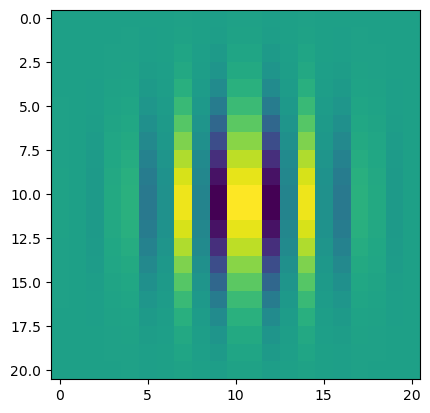

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
xmean, ymean = 0.5, 0.5
kernel_size = 21
fs = 21
sigmax, sigmay = 0.16, 0.16
freq = 6

x_, y_ = jnp.meshgrid(jnp.linspace(0,kernel_size/fs,num=kernel_size+1)[:-1], jnp.linspace(0,kernel_size/fs,num=kernel_size+1)[:-1])
g = model.gabor(x_, y_, xmean, ymean, sigmax, sigmay, freq=freq, theta=0, sigma_theta=0, rot_theta=0)
print(g.shape)
plt.imshow(g)
plt.show()

In [ ]:
kernel = model.return_kernel(params)
kernel.shape

(21, 21, 3, 1)

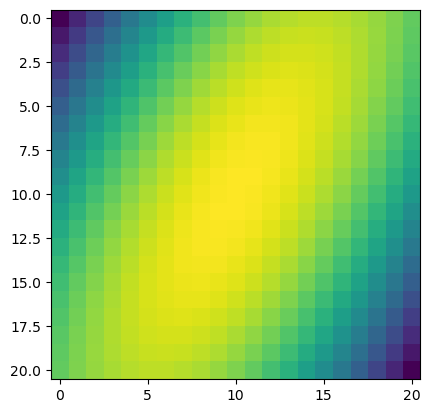

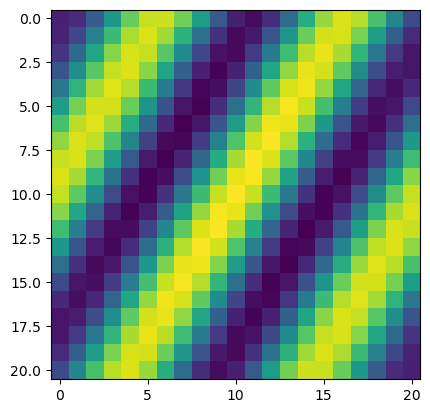

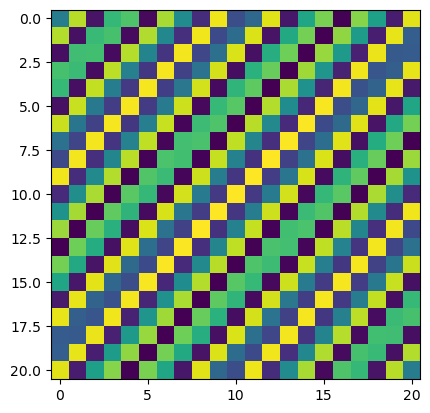

In [ ]:
#| eval: false
for k in jnp.transpose(kernel, (3,2,0,1))[0]:
    plt.imshow(k)
    plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 129 ms, sys: 14.6 ms, total: 144 ms
Wall time: 181 ms


In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 28.6 ms, sys: 102 µs, total: 28.7 ms
Wall time: 24.8 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).sum()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 2727.39111328125
Loss 100: 2427.29443359375
Loss 200: 2420.80859375
Loss 300: 2419.02734375
Loss 400: 2418.013916015625
Loss 500: 2417.444580078125
Loss 600: 2417.135009765625
Loss 700: 2416.9248046875
Loss 800: 2416.7763671875
Loss 900: 2416.669677734375
Loss 1000: 2416.58935546875


The loss is going down, so everything looking good so far!